# Sparkify Project

In [1]:
# Install pandas on EMR Notebook
sc.install_pypi_package("pandas==1.0.3")
sc.install_pypi_package("matplotlib==3.1.3")
sc.install_pypi_package("seaborn==0.10.1")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
8,application_1593604699653_0009,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached https://files.pythonhosted.org/packages/4a/6a/94b219b8ea0f2d580169e85ed1edc0163743f55aaeca8a44c2e8fc1e344e/pandas-1.0.3-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/d4/70/d60450c3dd48ef87586924207ae8907090de0b306af2bce5d134d78615cb/python_dateutil-2.8.1-py2.py3-none-any.whl

  Using cached https://files.pythonhosted.org/packages/4c/9b/35ab3469fd1509f7636a344940569ebfd33239673fd2318e80b4700a257c/matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/8a/bb/488841f56197b13700afd5658fc279a2025a39e22449b7cf29864669b15d/pyparsing-2.4.7-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/31/b9/6202dcae729998a0ade30e80ac00f616542ef445b088ec970d407dfd41c0/kiwisolver-1.2.0-cp37-cp37m-manylinux1_x86_64.whl

  Usi

In [2]:
# import libraries
from pyspark.sql import SparkSession, Window
import pyspark.sql.functions as F
from  pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType, FloatType
from pyspark.ml.stat import Correlation
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, Evaluator
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import time
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
# create a Spark session
spark = SparkSession.builder\
    .master("local")\
    .appName('Sparkify')\
    .getOrCreate()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
spark

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Check <a href="https://livy.apache.org/">Apache Livy</a> magic commands in Jupyter:

In [5]:
%help

Magic,Example,Explanation
info,%%info,Outputs session information for the current Livy endpoint.
cleanup,%%cleanup -f,"Deletes all sessions for the current Livy endpoint, including this notebook's session. The force flag is mandatory."
delete,%%delete -f -s 0,Deletes a session by number for the current Livy endpoint. Cannot delete this kernel's session.
logs,%%logs,Outputs the current session's Livy logs.
configure,"%%configure -f{""executorMemory"": ""1000M"", ""executorCores"": 4}",Configure the session creation parameters. The force flag is mandatory if a session has already been created and the session will be dropped and recreated.Look at Livy's POST /sessions Request Body for a list of valid parameters. Parameters must be passed in as a JSON string.
spark,%%spark -o dfdf = spark.read.parquet('...,"Executes spark commands. Parameters: -o VAR_NAME: The Spark dataframe of name VAR_NAME will be available in the %%local Python context as a Pandas dataframe with the same name. -m METHOD: Sample method, either take or sample. -n MAXROWS: The maximum number of rows of a dataframe that will be pulled from Livy to Jupyter. If this number is negative, then the number of rows will be unlimited. -r FRACTION: Fraction used for sampling."
display,%%display -n 100my_spark_df,"Displays Spark dataframe as a beautiful HTML table with horizontal and vertical scroll bars(if necessary). Parameters: -m METHOD: Sample method, either take or sample. -n MAXROWS: The maximum number of rows of a dataframe to display. If this number is negative, then the number of rows will be unlimited. -r FRACTION: Fraction used for sampling."
sql,%%sql -o tables -qSHOW TABLES,"Executes a SQL query against the variable sqlContext (Spark v1.x) or spark (Spark v2.x). Parameters: -o VAR_NAME: The result of the SQL query will be available in the %%local Python context as a Pandas dataframe. -q: The magic will return None instead of the dataframe (no visualization). -m, -n, -r are the same as the %%spark parameters above."
local,%%locala = 1,All the code in subsequent lines will be executed locally. Code must be valid Python code.


Useful: `%%spark -o df` will let the Spark Dataframe available locally as a Pandas dataframe

# Load and Clean Dataset
Using tiny subset (128MB) of the full dataset available (12GB) for local development.

full dataset: `s3n://udacity-dsnd/sparkify/full_sparkify_event_data.json`

Full dataset: `s3n://udacity-dsnd/sparkify/sparkify_event_data.json`


In [6]:
event_data = "s3n://udacity-dsnd/sparkify/sparkify_event_data.json"
df = spark.read.json(event_data)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
# Persist data on cluster
df.persist()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [8]:
# Check schema and column types
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

In [9]:
df.head(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(artist='Popol Vuh', auth='Logged In', firstName='Shlok', gender='M', itemInSession=278, lastName='Johnson', length=524.32934, level='paid', location='Dallas-Fort Worth-Arlington, TX', method='PUT', page='NextSong', registration=1533734541000, sessionId=22683, song='Ich mache einen Spiegel - Dream Part 4', status=200, ts=1538352001000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1749042'), Row(artist='Los Bunkers', auth='Logged In', firstName='Vianney', gender='F', itemInSession=9, lastName='Miller', length=238.39302, level='paid', location='San Francisco-Oakland-Hayward, CA', method='PUT', page='NextSong', registration=1537500318000, sessionId=20836, song='MiÃ\x83Â©ntele', status=200, ts=1538352002000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='1563081'), Row(artist='Lush', auth='Logged In', fi

In [10]:
%%spark -o df_head
df_head = df.limit(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
%local
df_head

Output()

In [12]:
print('Number of rows full dataset', df.count())
print('Number of columns full dataset', len(df.columns))
print('Number of duplicated rows in full dataset', df.count() - df.dropDuplicates().count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of rows full dataset 26259199
Number of columns full dataset 18
Number of duplicated rows in full dataset 0

#### Let's check our data for numerical columns:

In [13]:
numCols = [col[0] for col in df.dtypes if not col[1]=='string']; numCols

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['itemInSession', 'length', 'registration', 'sessionId', 'status', 'ts']

In [14]:
df.select(numCols).describe().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+------------------+--------------------+------------------+------------------+--------------------+
|summary|     itemInSession|            length|        registration|         sessionId|            status|                  ts|
+-------+------------------+------------------+--------------------+------------------+------------------+--------------------+
|  count|          26259199|          20850272|            25480720|          26259199|          26259199|            26259199|
|   mean|106.56267561702853|248.72543296748827|1.535220665260512...|100577.99253503505|210.06768953615074|1.540905636113772...|
| stddev|117.65812617523798| 97.28710387078071|3.2402990978250694E9|  71909.2107787595|31.550728788197627|1.5158105552718406E9|
|    min|                 0|             0.522|       1508018725000|                 1|               200|       1538352001000|
|    max|              1428|        3024.66567|       1543821822000|            240381|               40

For some informations above (`registration`, `sessionId`, `status`, `ts`) it doesn't make sense to analyze as numbers. We will dive deeper in the next Exploratory Data Analysis session of this notebook.

#### Let's check our data for categorical columns:

In [15]:
text_cols = [col[0] for col in df.dtypes if col[1]=='string']; text_cols

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['artist', 'auth', 'firstName', 'gender', 'lastName', 'level', 'location', 'method', 'page', 'song', 'userAgent', 'userId']

Although not expected by inspecting the data, `userId` is actually a string.

We check other information about our text data (not interested in `firstName` and `lastName`):

In [16]:
dist_artists = df.select(F.countDistinct('artist').alias('numberOfDistinctArtists')).withColumn("id", F.monotonically_increasing_id())

dist_songs = df.select(['song','artist']).groupBy('song').agg(F.countDistinct('artist').alias('countDistinctArtists')).\
    select(F.sum('countDistinctArtists').alias('numberOfDistinctSongs')).withColumn("id", F.monotonically_increasing_id())

dist_user_agents = df.select(F.countDistinct('userAgent').alias('numberOfuserAgents')).withColumn("id", F.monotonically_increasing_id())

dist_locations = df.select(F.countDistinct('location').alias('numberOfDistinctLocations')).withColumn("id", F.monotonically_increasing_id())

text_cols_info = dist_artists.join(dist_songs, "id", "outer")\
                             .join(dist_user_agents, "id", "outer")\
                             .join(dist_locations, "id", "outer").drop('id')\

text_cols_info.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------------+---------------------+------------------+-------------------------+
|numberOfDistinctArtists|numberOfDistinctSongs|numberOfuserAgents|numberOfDistinctLocations|
+-----------------------+---------------------+------------------+-------------------------+
|                  38337|               311148|                85|                      886|
+-----------------------+---------------------+------------------+-------------------------+

Sparkify's full dataset contains has 38337 different artists, 311148 songs, users in 886 different locations that use 85 different types of devices/software to access the app.

In [17]:
# We calculate value counts for:
text_cols_value_counts = ['auth',
                         'gender',
                         'level',
                         'method',
                         'page',
                         'status']

for column in text_cols_value_counts:
    df.select(column).groupBy(column).count().orderBy('count').show(30, truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+--------+
|auth      |count   |
+----------+--------+
|Guest     |4194    |
|Cancelled |5003    |
|Logged Out|774285  |
|Logged In |25475717|
+----------+--------+

+------+--------+
|gender|count   |
+------+--------+
|null  |778479  |
|F     |12181158|
|M     |13299562|
+------+--------+

+-----+--------+
|level|count   |
+-----+--------+
|free |5663371 |
|paid |20595828|
+-----+--------+

+------+--------+
|method|count   |
+------+--------+
|GET   |2389761 |
|PUT   |23869438|
+------+--------+

+-------------------------+--------+
|page                     |count   |
+-------------------------+--------+
|Submit Registration      |401     |
|Register                 |802     |
|Cancellation Confirmation|5003    |
|Cancel                   |5003    |
|Submit Downgrade         |6494    |
|Submit Upgrade           |15135   |
|Error                    |25962   |
|Save Settings            |29516   |
|Upgrade                  |50507   |
|About                    |92759   |
|Se

#### Loading, cleaning the dataset and checking for invalid or missing data - for example, records without userids or sessionids. 

In [18]:
#Checking if there are NaNs
df.select([F.count(F.when(F.isnan(c), c)).alias(c+'IsNan') for c in df.columns]).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   artistIsNan  authIsNan  firstNameIsNan  ...  tsIsNan  userAgentIsNan  userIdIsNan
0            0          0               0  ...        0               0            0

[1 rows x 18 columns]

No Nans in the full dataset.

In [19]:
#Checking if there are null values
df.select([F.count(F.when(col(c).isNull(), c)).alias(c+'IsNull') for c in df.columns]).toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   artistIsNull  authIsNull  ...  userAgentIsNull  userIdIsNull
0       5408927           0  ...           778479             0

[1 rows x 18 columns]

Appearently missing data is correlated (missing counts of columns consistently appear having 8346 or 58392 Null values).

Let's check how missing values are correlated:

In [20]:
# Check null values: 1 is null and 0 not null
df_is_null = df.select([F.when(col(c).isNull(), 1).otherwise(0).alias(c) for c in df.columns])

df_is_null_describe = df_is_null.describe()

df_is_null_describe = df_is_null_describe.filter(
    (df_is_null_describe['summary']=='stddev') | 
    (df_is_null_describe['summary'] == 'max')
)

# Handle the std equals to zero (all values are the same) and without any null value
zero_std_max_cols = [col for col in df_is_null_describe.columns if df_is_null_describe.select(F.collect_list(col)).head().asDict()['collect_list('+col+')'] == ['0.0', '0']]

# Drop all columns with Standard Deviation equals zero and no missing values
df_is_null = df_is_null.drop(*zero_std_max_cols)

# Create vectors 
assembler = VectorAssembler(inputCols=df_is_null.columns, outputCol='vector')
assembled = assembler.transform(df_is_null).drop(*df_is_null.columns)

# Calculate and print Pearson correlation matrix for missing values
pearson_corr = Correlation.corr(assembled, 'vector').head()
pearson_corr = pd.DataFrame(data=pearson_corr[0].toArray(), columns=df_is_null.columns, index=df_is_null.columns)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
fig, ax = plt.subplots(figsize=(8, 10))
sns.heatmap(pearson_corr, ax=ax, annot=True);

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

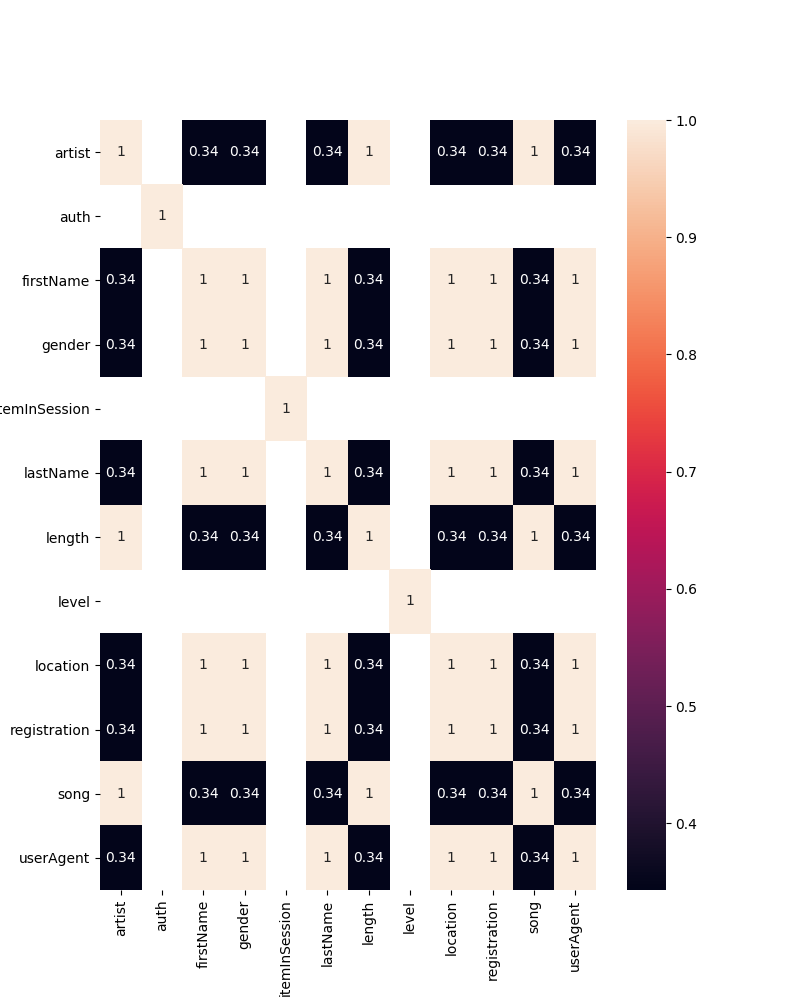

In [22]:
%matplot plt

When there's a null in `artist` column also a null in `length` and `song` happen. Hence, this data may be related and length appears to be the length in seconds of songs. 

Similarly, data related to users are related and when a null happens in either `firstName`, `lastName`, `gender`, `location`, `userAgent` and `registration` the others are null too. The column registration seems to be related to the timestamp of when a user registers himself/herself in the application.

Let's check `userId`:

In [23]:
# userId is string and shold be always with length greater than 0
df.select('userId', F.length(col('userId')).alias('userIdLength')).distinct().orderBy(col('userIdLength')).show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------+
| userId|userIdLength|
+-------+------------+
|1310157|           7|
|1596267|           7|
|1971226|           7|
|1051690|           7|
|1806732|           7|
+-------+------------+
only showing top 5 rows

In [24]:
# number of users with userId equals to ''
df.filter(df.userId=='').count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0

In the full dataset there are no users with userId equals to `''` (length of the string userId is zero). Perhaps those users without userId are those who have not signed up yet or that are signed out and are about to log in and somehow were only in the mini-dataset.

We'll drop them from our dataframe (in order for the analysis of individual users make sense):

In [25]:
# Drop userId equals to ''
df = df.filter(df.userId!='')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
# Full dataset has 26,259,199 rows. It should stay the same
df.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

26259199

In [27]:
print(f"There are {df.select('userId').distinct().count()} users in the full dataset.")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

There are 22278 users in the full dataset.

# Exploratory Data Analysis

### Define Churn

We create a column `Churn` to use as the label for our model. We choose the `Cancellation Confirmation` events to define the churn, which happen for both paid and free users. We also analyze the `Downgrade` events.

In [28]:
# Create Churn column
churner_ids = df.select('userId').where(col('page')=='Cancellation Confirmation').toPandas()
churner_ids = churner_ids.values.squeeze().tolist()
print('churner_ids:', churner_ids[:20])
print('\nTotal churners in full dataset:', len(churner_ids))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

churner_ids: ['1768454', '1381915', '1298443', '1379352', '1068112', '1362621', '1276848', '1277353', '1274097', '1163202', '1809551', '1625954', '1015368', '1714714', '1467284', '1417019', '1191242', '1487256', '1231207', '1985954']

Total churners in full dataset: 5003

In [29]:
all_ids = df.select('userId').distinct().toPandas()
all_ids = all_ids.values.squeeze().tolist()
print('Total distinct users in full dataset:', len(all_ids))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total distinct users in full dataset: 22278

In [30]:
not_churner_ids = np.setdiff1d(all_ids, churner_ids).tolist()
print('not_churner_ids:', not_churner_ids[:20], '...')
print('\nTotal churners in full dataset:', len(not_churner_ids))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

not_churner_ids: ['1000035', '1000103', '1000164', '1000168', '1000182', '1000194', '1000214', '1000233', '1000244', '1000248', '1000407', '1000409', '1000446', '1000527', '1000611', '1000625', '1000626', '1000655', '1000662', '1000908'] ...

Total churners in full dataset: 17275

In [31]:
%spark -o df_head
is_churn = udf(lambda usrIdCol: 1 if usrIdCol in churner_ids else 0, IntegerType())
df = df.withColumn('churn', is_churn('userId'))

df_head = df.limit(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
%local
df_head

Output()

### Explore Data
Analyzing the behavior for users who stayed vs users who churned. 
We explore aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

Without knowing much about the business nor the actual application, we can think the following possible reasons why users cancel the service:
1. user is not using Sparkify
2. Sparkify doesn't have specific songs/artists
3. bad recommendations
4. bad experience (streaming getting stuck, interface not intuitive in version of app, too many ads in the app, etc.)
5. bugs (commands not responding or don't do what they should, crashes in the app, etc.)
6. Sparkify too expensive
7. don't have friends using Sparkify
8. external influences (some news about company benefits/harms its image, country where users live imposes some limits, cost increase, etc.)

From the hypothesis above:
- `1.` we can check by counting number of interations in a given timeframe
- `2.` we cannot check directly since we don't have logs for search queries which would be better (showing that the search query returned exactly what the user wanted) 
- `3.` we have the Add to Playlist, Thumbs Down and Thumbs Up `pages` which could indicate the quality of recommendations
- `4.` and `5.` we don't have application logs which could indicate loading times, interrupting streaming. However, <a href="https://www.w3.org/Protocols/rfc2616/rfc2616-sec10.html#sec10.3.3">status</a> could give us some information about the application and the Error and Help `pages`. In addition, <a href="https://developer.mozilla.org/en-US/docs/Web/HTTP/Headers/User-Agent">userAgent</a> can also give us some information about Sparkify applications that are not behaving as expected (Windows, MacOS, specific browser, platform, etc.). The Roll Advert `page` indicates Advertising events and if it is affecting too much user experience (if we could reduce it or enphasize that user can upgrade plan)
- `6.` as "expensive" may be an ambiguous definition and depend on many factors, with the dataset given we won't be able to infer anything.
- `7.` Add Friend `page` could indicate that friends are also using app (in the provided dataset we don't have relationships between users which would be better)
- `8.` again we would need more data related to the business and context to infer anything here

We check the data to answer those questions and compare customers who churn with those who don't:

In [33]:
not_churn_users = df.filter(col('churn')==0)
churn_users = df.filter(col('churn')==1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [34]:
num_churn_users = churn_users.select('userId').distinct().count()
num_not_churn_users = not_churn_users.select('userId').distinct().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
# Sanity check (there should be 22278 users in total in the full dataset)
print('Number of users who churn:', num_churn_users)
print("Number of users who don't churns", num_not_churn_users)
print('Total (should be 26,259,199 users):', num_churn_users + num_not_churn_users)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Number of users who churn: 5003
Number of users who don't churns 17275
Total (should be 26,259,199 users): 22278

As we see, there is class imbalance in the fulldataset with ~22% of users who churn and ~78% of users who don't churn.

#### Some analysis

In [36]:
# How many songs do users listen to on average between visiting our home page (calculation shown in the Udacity course)

fun = udf(lambda ishome : int(ishome == 'Home'), IntegerType())

user_window = Window \
    .partitionBy('userID') \
    .orderBy(F.desc('ts')) \
    .rangeBetween(Window.unboundedPreceding, 0)

cusum_churn = churn_users.filter((col('page') == 'NextSong') | (col('page') == 'Home')) \
    .select('userID', 'page', 'ts') \
    .withColumn('homevisit', fun(col('page'))) \
    .withColumn('period', F.sum('homevisit').over(user_window))

cusum_churn = cusum_churn.filter((col('page') == 'NextSong')) \
    .groupBy('userID', 'period') \
    .agg({'period':'count'}) \
    .agg({'count(period)':'avg'}).withColumnRenamed('avg(count(period))', 'churnAvg(count(period))') \
    .withColumn("id", F.monotonically_increasing_id())

cusum_not_churn = not_churn_users.filter((col('page') == 'NextSong') | (col('page') == 'Home')) \
    .select('userID', 'page', 'ts') \
    .withColumn('homevisit', fun(col('page'))) \
    .withColumn('period', F.sum('homevisit').over(user_window))

cusum_not_churn = cusum_not_churn.filter((col('page') == 'NextSong')) \
    .groupBy('userID', 'period') \
    .agg({'period':'count'}) \
    .agg({'count(period)':'avg'}).withColumnRenamed('avg(count(period))', 'notChurnAvg(count(period))') \
    .withColumn("id", F.monotonically_increasing_id())

result = cusum_churn.join(cusum_not_churn, "id", "outer").drop('id')\

result.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------------+--------------------------+
|churnAvg(count(period))|notChurnAvg(count(period))|
+-----------------------+--------------------------+
|     23.048179539590876|         23.33570885918064|
+-----------------------+--------------------------+

Interestingly in the full-dataset the number of songs users listen to on average between visiting our home page is similar in the not churn group and in the group of users who churn.

In [37]:
# Calculating number of songs played given time frame

def add_time_columns(df):
    # Add hour column
    get_hour = udf(lambda x: int(datetime.fromtimestamp(x / 1000.0).hour), IntegerType())
    df_time = df.withColumn('hour', get_hour(df.ts))
    songs_in_hour = df_time.filter(df_time.page == 'NextSong').groupby('hour').count().orderBy('hour')
    songs_in_hour_pd = songs_in_hour.toPandas()

    # Add weekday column
    get_weekday = udf(lambda x: int(datetime.fromtimestamp(x / 1000.0).weekday()), IntegerType())
    df_time = df_time.withColumn('weekday', get_weekday(df_time.ts))
    songs_in_weekday = df_time.filter(df_time.page == 'NextSong').groupby('weekday').count().orderBy('weekday')
    songs_in_weekday_pd = songs_in_weekday.toPandas()
    songs_in_weekday_pd.weekday = songs_in_weekday_pd.weekday.map({0: 'Mon', 1: 'Tue', 2: 'Wed', 3: 'Thu', 4: 'Fri', 5: 'Sat', 6: 'Sun'})
    
    return songs_in_hour_pd, songs_in_weekday_pd

churn_songs_hour, churn_songs_weekday = add_time_columns(churn_users)
not_churn_songs_hour, not_churn_songs_weekday = add_time_columns(not_churn_users)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [38]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].scatter(churn_songs_hour['hour'], churn_songs_hour['count']/num_churn_users, label='churn')
ax[0].scatter(not_churn_songs_hour['hour'], not_churn_songs_hour['count']/num_not_churn_users, label='not churn')
ax[0].set_xlim(-1, 24)
ax[0].set_ylim(0, 1.2 * max(not_churn_songs_hour["count"]/num_not_churn_users))
ax[0].set_xlabel("Hour")
ax[0].set_ylabel("Songs played per user")
ax[0].set_title("Songs played by Hour")
ax[0].legend(loc='best')
ax[1].scatter(churn_songs_weekday['weekday'], churn_songs_weekday['count']/num_churn_users, label='churn')
ax[1].scatter(not_churn_songs_weekday['weekday'], not_churn_songs_weekday['count']/num_not_churn_users, label='not churn')
ax[1].set_xlim(-0.5, 6.5)
ax[1].set_ylim(0, 1.2 * max(not_churn_songs_weekday["count"]/num_not_churn_users))
ax[1].set_xlabel("Week day")
ax[1].set_ylabel("Songs played per user")
ax[1].set_title("Songs played by Week day")
ax[1].legend(loc='best')
fig.tight_layout();

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

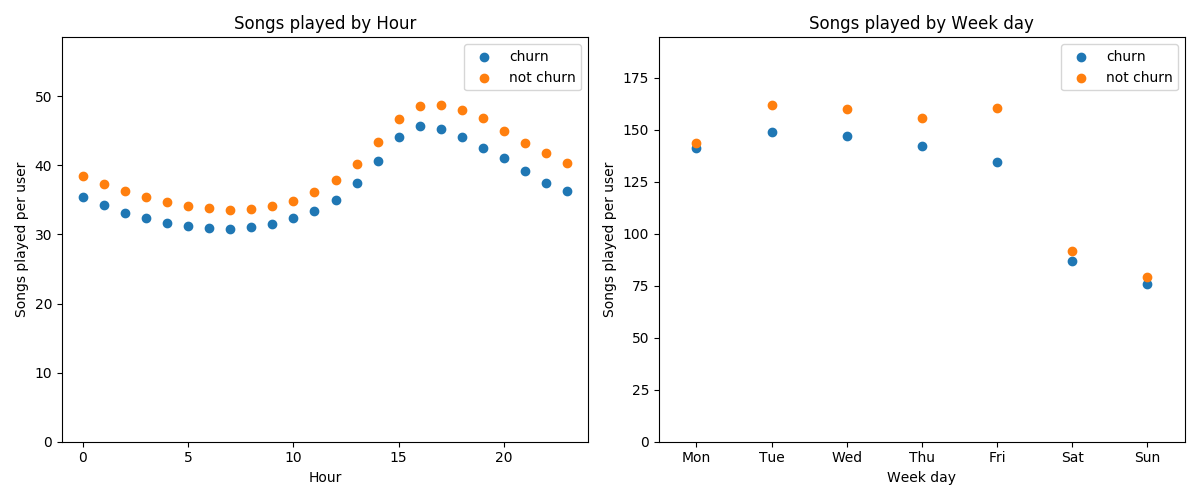

In [39]:
%matplot plt

Users that churn and those who don't behave similarly w.r.t. the time, however playing less songs in the churn group.

In [40]:
# How the number of interactions change over time, since user registrates

earliest = df.select('ts').orderBy(col('ts')).head()
latest = df.select('ts').orderBy(col('ts'), ascending=False).head()

print(f'Earliest record in full dataset is {datetime.fromtimestamp(earliest.ts / 1000.0)}')
print(f'Latest record in full dataset is {datetime.fromtimestamp(latest.ts / 1000.0)}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Earliest record in full dataset is 2018-10-01 00:00:01
Latest record in full dataset is 2018-12-01 00:00:02

In [41]:
# Count actions per user per day
# We randomly select 1 user who have churned and 1 user who haven't churned for comparison
churner = np.random.choice(churner_ids, size=1, replace=False).tolist()
not_churner = np.random.choice(not_churner_ids, size=1, replace=False).tolist()

def get_actions_by_day(df, ids):
    actions = df.where(df.userId.isin(ids))\
        .withColumn('day', F.date_trunc('day', F.from_unixtime(col('ts')/1000)))\
        .groupBy('userId', 'day', 'page').agg({'page': 'count'})\
        .orderBy('userId','day', 'page')

    # We want each line to be a day, and columns for counts of each page action
    actions = actions.groupBy(col('userId'), col('day')).pivot('page')\
        .agg(F.first('count(page)')).drop('page').orderBy('userId','day')

    # In order to compare users, we transform day of the month in a running day number (e.g. if )
    first_interactions = actions.select('userId', 'day').groupBy('userId').agg({'day': 'min'})
    actions = actions.join(first_interactions, on='userId').withColumn('runningDaysFromFirstInteration', F.datediff('day',col('min(day)'))).drop('min(day)')
    
    # Fill nulls with zeros (no actions of that type in the day)
    actions = actions.fillna(0)
    return actions

churner_actions = get_actions_by_day(df, churner)
not_churner_actions = get_actions_by_day(df, not_churner)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [42]:
churner_actions_pd = churner_actions.toPandas()
not_churner_actions_pd = not_churner_actions.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [43]:
churner_actions_pd['churn'] = pd.Series(np.ones(churner_actions_pd.shape[0]))
not_churner_actions_pd['churn'] = pd.Series(np.zeros(churner_actions_pd.shape[0]))
churner_actions_pd.drop('day', axis=1, inplace=True)
not_churner_actions_pd.drop('day', axis=1, inplace=True)
actions = pd.concat([churner_actions_pd, not_churner_actions_pd])

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [44]:
cols = churner_actions_pd.columns[1:-2]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [45]:
ax_i = int(np.ceil(cols.shape[0]/5))
ax_j = 5

fig, ax = plt.subplots(ax_i, ax_j, figsize=(26,16))
for i in range(ax_i):
    for j in range(ax_j):
        sns.lineplot(x='runningDaysFromFirstInteration', y=cols[j + 5*i], hue='churn', data=actions, ax=ax[i][j])
        ax[i][j].set_title(f'Action "{cols[j + 5*i]}" vs day')
        if (j + 5*i) == len(cols)-1:
            break
fig.tight_layout();

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

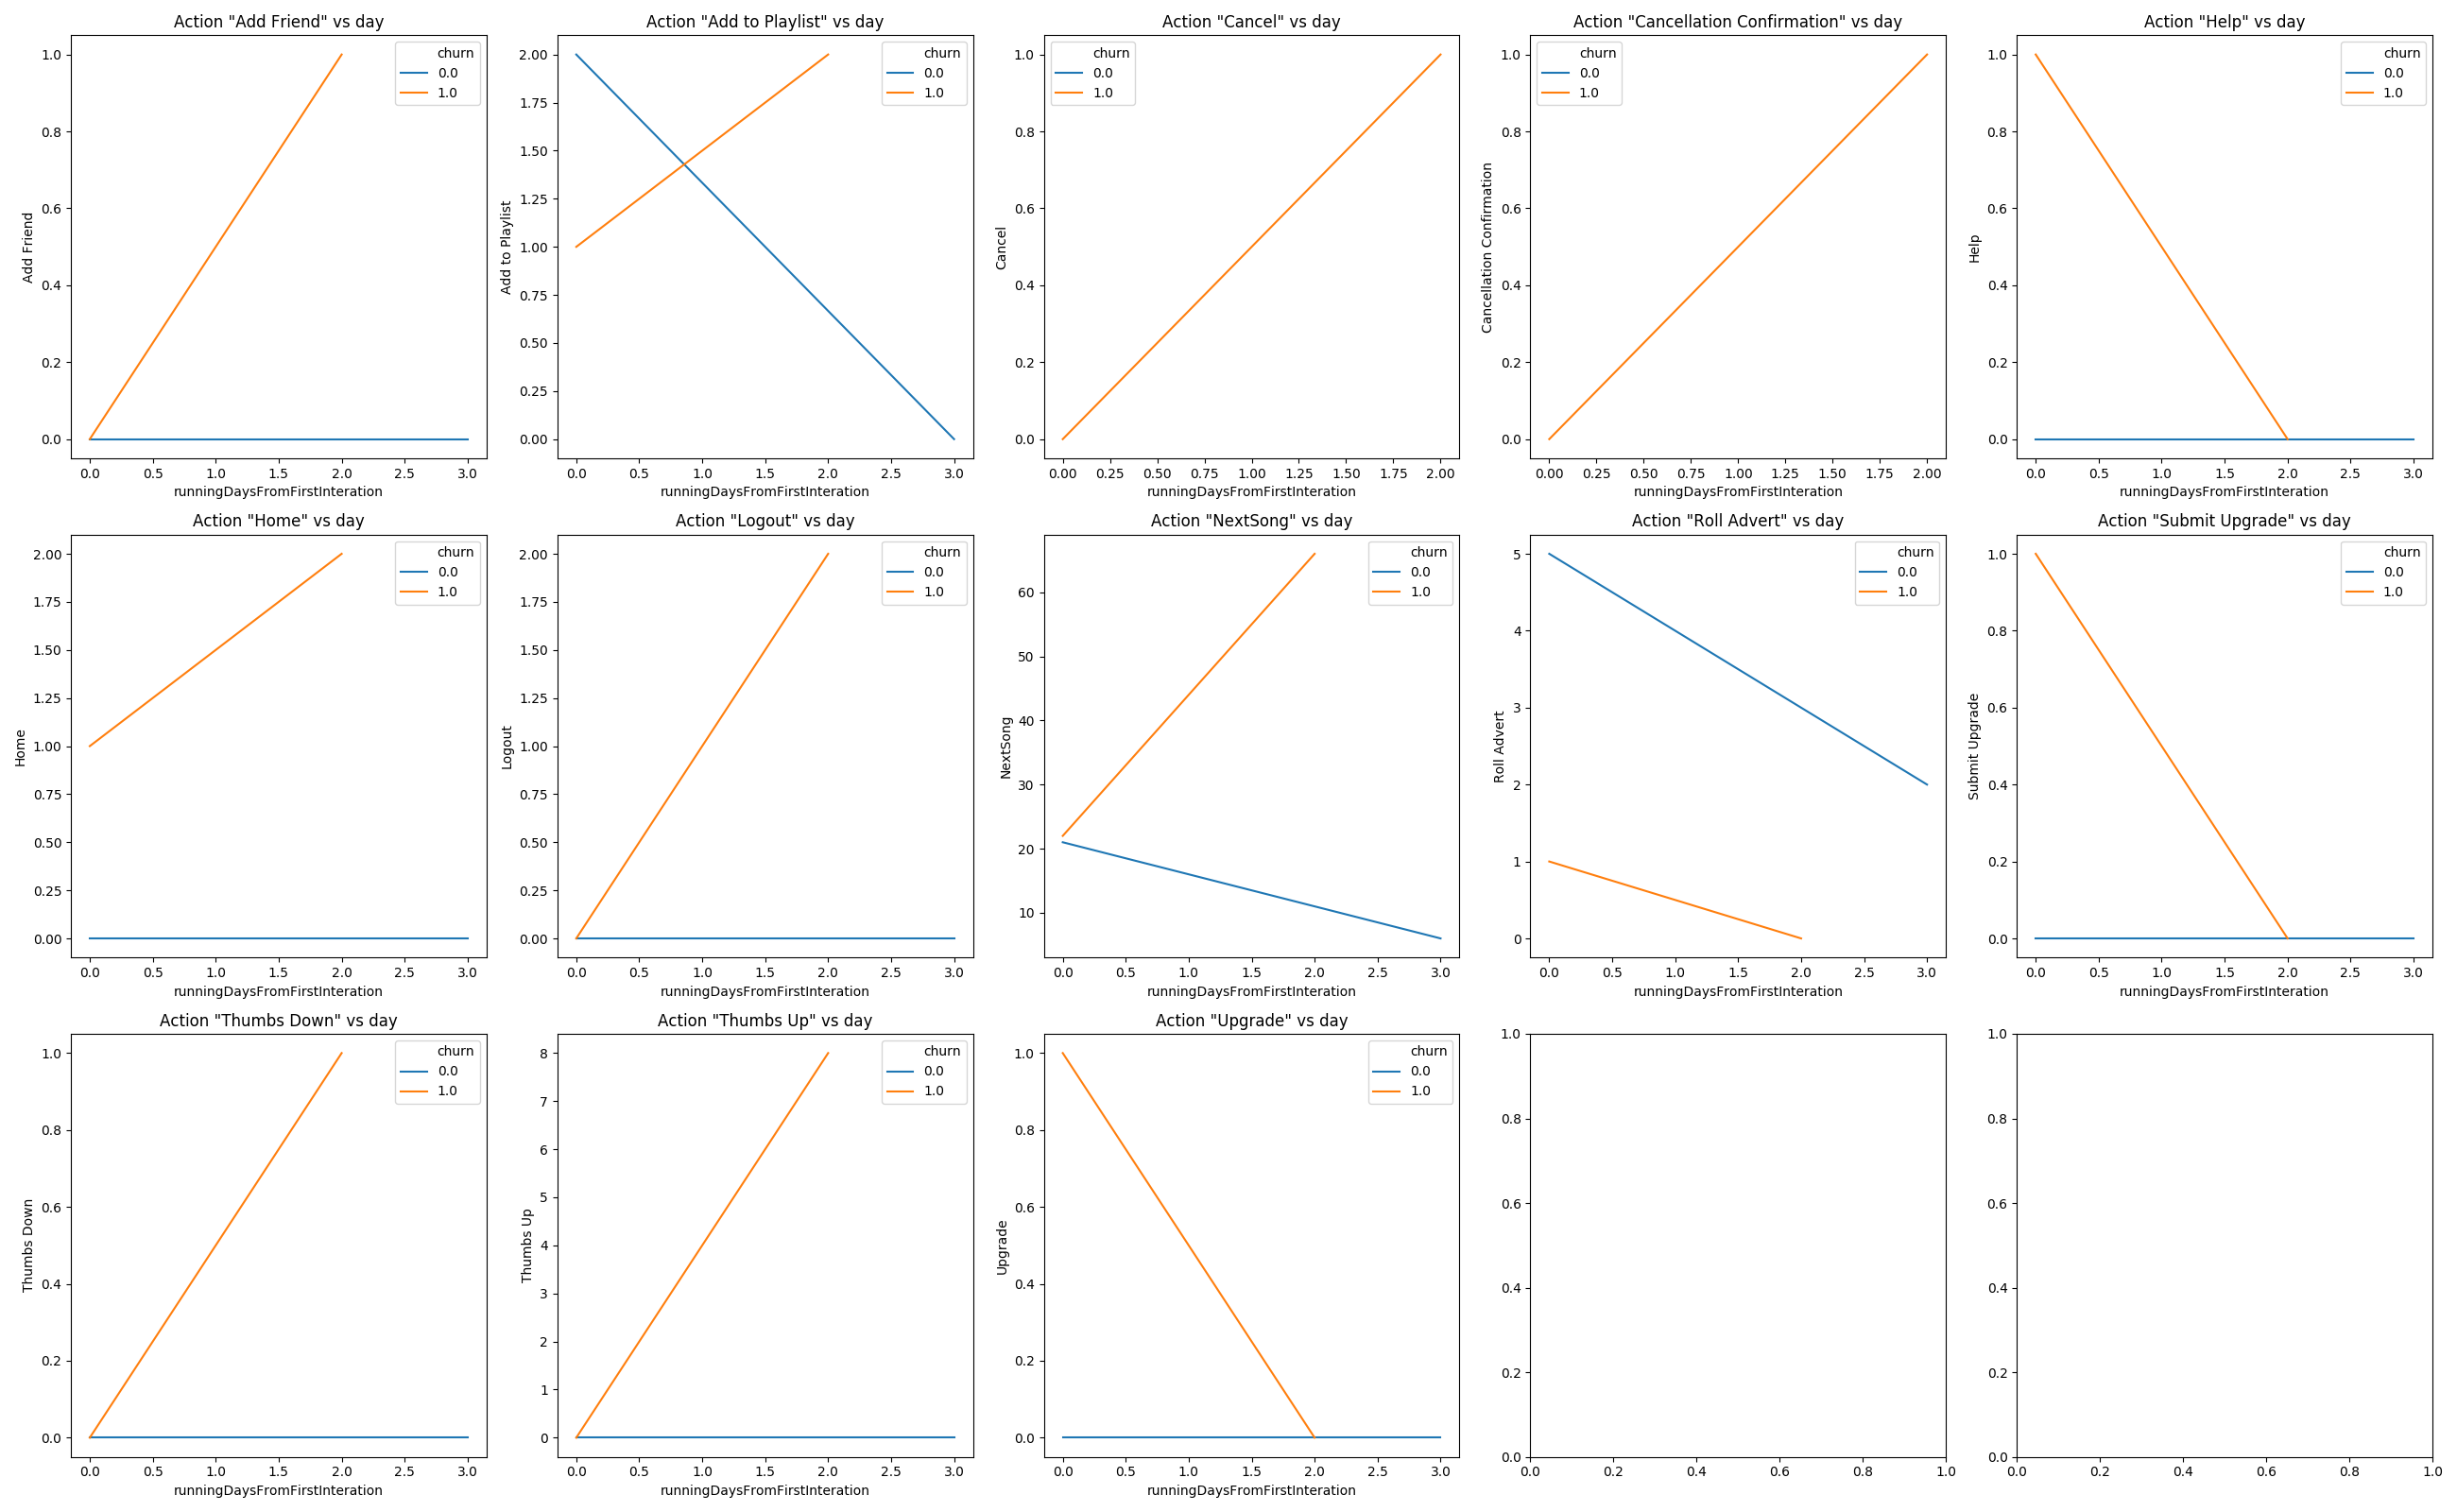

In [46]:
%matplot plt

In [47]:
# Users who Downgrade Their Accounts

# We find when users downgrade their accounts and then flag those log entries. 
# Then we use a window function to create 2 phases (0 for pre-downgrade 1 for pos-downgrade) using a cumulative sum for each user.

flag_downgrade_event = udf(lambda x: 1 if x == 'Submit Downgrade' else 0, IntegerType())

df_downgraded = df.withColumn('downgraded', flag_downgrade_event('page'))

windowval = Window.partitionBy('userId').orderBy(F.desc('ts')).rangeBetween(Window.unboundedPreceding, 0)

df_downgraded = df_downgraded.withColumn('phase', F.sum('downgraded').over(windowval))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [48]:
%spark -o df_downgraded_1994680
# Taking userId 1994680 as example
df_downgraded_1994680 = df_downgraded.select(["userId", "firstname", "ts", "page", "level", "downgraded", "phase"])\
                                .where(col('userId') == "1994680").sort(F.desc("ts"))\

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [49]:
%local
df_downgraded_1994680.iloc[7:26,:]

Output()

# Feature Engineering

We need to make each row of our dataset to be an user.

Possible features (considering only all account time, not aggregations in recent vs distant events):
- artist: distinct artists listened
- song: distinct songs listened
- length: average length of songs listened
- gender: one-hot encode (M/F)
- itemInSession: average items in session
- sessionId: can be used calculate average length of sessions
- level: one-hot encode (Free/Paid)
- location: percentage of interactions of user at specific location
- page: counts by page type
- status: counts by status codes
- userAgent: get percentage of interactions of user using specific user agent - device, system information, platform, etc.
- accountLifeTime: time an user has an account, from the first interaction until the present or the moment he/she cancels account

In [50]:
# Helper functions for cleaning and calculating percentages
def get_mappings(cols, prefix):
    mapping = dict()
    for i, c in enumerate(cols):
        mapping[prefix+str(i)] = c
    return mapping

def calculate_perc(percentage_df , mappings):
    for new_name, existing_name in mappings.items():
        percentage_df = percentage_df.withColumnRenamed(existing_name, new_name)
        percentage_df = percentage_df.withColumn(new_name, col(new_name)/col('userTotalInterations'))

    percentage_df = percentage_df.drop('userTotalInterations')
    return percentage_df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [51]:
def compute_features(df):
    '''
    Function for computing features.
    
    Parameters
    ----------
    input: Spark dataframe with schema of raw dataset and data
    
    Returns
    -------
    df_features: Spark dataframe with computed features
    location_mappings: dict for encoded locations
    sys_agent_mappings: dict for encoded system information from user-agent
    plat_agent_mappings: dict for encoded platform information from user-agent
    '''
    # Create `day` column for aggregating days and keeping information about month and year
    df_features = df
#     print('df_features RAW shape (row, cow)', df_features.count(), len(df_features.columns))
    df_features = df_features.withColumn('day', F.date_trunc('day', F.from_unixtime(col('ts')/1000)))

    # Create `userAgentSystemInformation` and `userAgentPlatform` columns for retrieving separate information from `userAgent`
    df_features = df_features.withColumn('userAgentSystemInformation', F.regexp_extract(col('userAgent'),'(?<=\().+?(?=\))',0))
    df_features = df_features.withColumn('userAgentPlatform', F.regexp_extract(col('userAgent'),'(?<=\)).+',0))  
    df_features = df_features.drop('userAgent')

    # Intermediate DF to calculate counts of actions by page type, per user
    page_counts = df_features.groupBy('userId', 'page')\
        .agg({'page': 'count'})\
        .groupBy(col('userId')).pivot('page')\
        .agg(F.first('count(page)')).drop('page')\
        .fillna(0)

    # Intermediate DF to calculate average length of user sessions
    session_avg_length = df_features.groupby('userId', 'sessionId')\
                            .agg(
                                F.min(col('ts')).alias('startSession'), 
                                F.max(col('ts')).alias('endSession')
                            )\
                            .groupby('userId')\
                            .agg(
                                F.avg(col('endSession')-col('startSession')).alias('avgSessionLength')
                            )

    # Intermediate DF to calculate percentage of interactions at specific location, per user
    location_percentage = df_features.groupBy('userId', 'location').agg({'location': 'count'})
    total_interations = df_features.groupBy('userId').agg(F.count('userId').alias('userTotalInterations'))

    location_percentage = location_percentage.groupBy(col('userId')).pivot('location')\
        .agg(F.first('count(location)'))\
        .fillna(0).join(total_interations,on='userId').drop('location')

    location_cols = location_percentage.columns
    location_cols.remove('userId')
    location_cols.remove('userTotalInterations')
    
    # Deal with bad column names
    location_mappings = get_mappings(location_cols, 'location_')
    location_percentage = calculate_perc(location_percentage , location_mappings)


    # Intermediate DF to calculate percentage of interactions using specific user-agent system information, per user
    countSysInfo = df_features.groupBy('userId', 'userAgentSystemInformation')\
        .agg(
            F.count('userAgentSystemInformation').alias('sysInfoCount')
        )

    total = df_features.groupBy('userId').agg(F.count('userId').alias('userTotalInterations'))

    countSysInfo = countSysInfo.groupBy(col('userId')).pivot('userAgentSystemInformation')\
        .agg(F.first('sysInfoCount'))\
        .fillna(0).join(total,on='userId').drop('userAgentSystemInformation')

    sys_cols = countSysInfo.columns
    sys_cols.remove('userId')
    sys_cols.remove('userTotalInterations')
    
    # Deal with bad column names
    sys_agent_mappings = get_mappings(sys_cols, 'sys_agent_')
    percentage_sys_info = calculate_perc(countSysInfo , sys_agent_mappings)
    
    # Intermediate DF to calculate percentage of interactions using specific user-agent platform information, per user
    countPlat = df_features.groupBy('userId', 'userAgentPlatform')\
        .agg(
            F.count('userAgentPlatform').alias('platformCount')
        )
    
    countPlat = countPlat.groupBy(col('userId')).pivot('userAgentPlatform')\
        .agg(F.first('platformCount'))\
        .fillna(0).join(total,on='userId').drop('userAgentPlatform')

    plat_cols = countPlat.columns
    plat_cols.remove('userId')
    plat_cols.remove('userTotalInterations')
    
    # Deal with bad column names
    plat_agent_mappings = get_mappings(plat_cols, 'plat_agent_')
    percentage_plat = calculate_perc(countPlat , plat_agent_mappings)
    
    
#     print('page_counts shape (row, cow)', page_counts.count(), len(page_counts.columns))
#     print('session_avg_length shape (row, cow)', session_avg_length.count(), len(session_avg_length.columns))
#     print('location_percentage shape (row, cow)', location_percentage.count(), len(location_percentage.columns))
#     print('percentageSysInfo shape (row, cow)', percentage_sys_info.count(), len(percentage_sys_info.columns))
#     print('percentagePlat shape (row, cow)', percentage_plat.count(), len(percentage_plat.columns))
    
    df_features = df_features.groupby('userId')\
                .agg(
                    F.countDistinct('artist').alias('distinctArtistsListened'),
                    F.countDistinct('song').alias('distinctSongsListened'), # simplification, disregarding songs with the same name and different artists
                    F.avg('length').alias('avgLength'),
                    F.first(F.when(col('gender') == 'M', 1).otherwise(0)).alias('isMale'),
                    F.avg('itemInSession').alias('avgItemsInSession'),
                    F.sum(F.when(col('level') == 'Paid', 1).otherwise(0)).alias('interactionsPaid'),
                    F.sum(F.when(col('level') == 'Free', 1).otherwise(0)).alias('interactionsFree'),
                    F.sum(F.when(col('status') == 307, 1).otherwise(0)).alias('statusCount307'),
                    F.sum(F.when(col('status') == 404, 1).otherwise(0)).alias('statusCount404'),
                    F.sum(F.when(col('status') == 200, 1).otherwise(0)).alias('statusCount200'),
                    F.min('day').alias('firstInteraction'),
                    F.max('day').alias('lastInteraction'),                
                )
    
#     print('df_features after AGGs shape (row, cow)', df_features.count(), len(df_features.columns))
    
    df_features = df_features.join(page_counts, on='userId')\
            .join(session_avg_length, on='userId')\
            .join(location_percentage, on='userId')\
            .join(percentage_sys_info, on='userId')\
            .join(percentage_plat, on='userId')
    
#     print('df_features after JOINs shape (row, cow)', df_features.count(), len(df_features.columns))

    df_features = df_features.withColumn('accountLifeTime', F.datediff( col('lastInteraction'), col('firstInteraction') ) )
    df_features = df_features.drop('lastInteraction','firstInteraction')
    
#     print('df_features after NEW COL shape (row, cow)', df_features.count(), len(df_features.columns))

    # Handle NaNs, Nulls
    df_features = df_features.fillna(0)
    
#     print('df_features after FILLNA shape (row, cow)', df_features.count(), len(df_features.columns))
        
    return df_features, location_mappings, sys_agent_mappings, plat_agent_mappings

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [52]:
start = time.time()
df_features, location_mappings, sys_agent_mappings, plat_agent_mappings = compute_features(df)
end = time.time()
print(f'Spent {end-start}s in feature computation')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Spent 582.0047855377197s in feature computation

In [53]:
# Add churn column as label
churn = df.select('userId','churn').distinct()
df_features_label = df_features.join(churn, on='userId')
df_features_label = df_features_label.withColumnRenamed('churn', 'label')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [54]:
%spark -o df_features_label -n 5

# Drop userId, as it's not a feature
df_features_label = df_features_label.drop('userId')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [55]:
%local
df_features_label

Output()

In [56]:
print('df_features_label shape:', df_features_label.count(), len(df_features_label.columns))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

df_features_label shape: 22278 999

In [57]:
# Save features in my S3 bucket called emr-sparkify, partitioning by date
now = datetime.now()
s3_path = f's3n://emr-sparkify/processed/{now.year}/{now.month}/{now.day}/{now.hour}/{now.minute}'

print(f'Saving data in {s3_path}...')
df_features_label.write.csv(s3_path, mode='overwrite', header=True)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Saving data in s3n://emr-sparkify/processed/2020/7/1/23/16...

As seen, EMR has processed and saved the data partitioned by date in the S3 bucket and in multiple csv files:

<img src="./media/s3.png" alt="s3">

For simplifications (after several trials with different cluster configurations, number of instances, adding spot task instances amd timeouts from JupyterLab), I broke the work into 2 notebooks. The [second notebook](./Sparkify-cluster.ipynb) focus on modeling and evaluating the results.

In the data pipeline breaing the logic here in 3 Spark applications would make sense:

- one for processing features
- one for training (when desired)
- another one for inference.